<a href="https://colab.research.google.com/github/sokrypton/ws2023/blob/main/day2/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

## Introduction to plot.ly

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
x = np.random.normal(size=100)
y = np.random.normal(size=100)
plt.scatter(x,y)

In [ ]:
px.scatter(x,y)

In [ ]:
xy = np.random.normal(size=(10,10))
plt.imshow(xy)
plt.colorbar()

In [ ]:
px.imshow(xy)

In [ ]:
z = np.random.normal(size=100)
px.scatter_3d(x=x,y=y,z=z)

## Introduction to SKLEARN

In [ ]:
# sklearn
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs

# dimensionality reduction methods
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

In [ ]:
#@title secret plotting functions <- RUN THIS
import plotly.graph_objs as go
from matplotlib.colors import ListedColormap
colorway = ["#1f77b4", "#ff7f0e", "#2ca02c",
              "#d62728","#9467bd", "#8c564b",
              "#e377c2", "#7f7f7f", "#bcbd22",
              "#17becf"]

c10 = lambda x: ListedColormap(colorway[:x])

def make_2D_plot(values, groups=None, s=10, c=None, cmap=None):
  '''
  Given values and groups, returns a scatter plot colored by group
  '''
  if groups is None:
    groups = np.zeros(len(values),int)
    if c is None: c = np.arange(len(values))
    if cmap is None: cmap = "plasma"
  for group in np.unique(groups):
    idx = groups == group
    plt.scatter(values[idx, 0], values[idx, 1],
                label=group, s=s, c=c, cmap=cmap)
  if len(np.unique(groups)) > 1:
    plt.legend(bbox_to_anchor=(1, 0, 0.5, 1), loc="upper left",)
  plt.axis("equal")

def make_3D_plot(values, groups=None, s=3):
  if groups is None:
    groups = np.zeros(len(values),int)
    if values.shape[-1] > 3:
      c = values[:,3]
      c = (c - c.min()) / (c.max() - c.min())
    else:
      c = None
  print(c)
  plot = []
  for group in np.unique(groups):
    idx = groups == group
    plot.append(go.Scatter3d(
        x=values[idx,0],
        y=values[idx,1],
        z=values[idx,2],
        name=str(group),
        mode='markers',
        marker=dict(size=s,color=c)))

  go.Figure(data=plot,layout=go.Layout(
      colorway=colorway, scene={"aspectmode":"data"})).show()

In [ ]:
# n_features = number of dimensions
A, groups = make_blobs(n_samples=500, n_features=5, centers=5)

In [ ]:
# making life a little easier
# plot in 2D
make_2D_plot(A, groups)

# use MDS to reduce to 2 dimensions

In [ ]:
B = MDS(n_components=2).fit_transform(A)

In [ ]:
make_2D_plot(B, groups)
plt.xlabel("mds 1")
plt.ylabel("mds 2")

In [ ]:
# comparing pairwise distances in 5D space and 2D space!
dm_A = pairwise_distances(A)
dm_B = pairwise_distances(B)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("dm(A)")
plt.imshow(dm_A,cmap="Greys")
plt.subplot(1,2,2); plt.title("dm(B)")
plt.imshow(dm_B,cmap="Greys")
plt.show()

In [ ]:
plt.scatter(dm_A, dm_B, s=1)
plt.xlabel("dm(A)")
plt.ylabel("dm(A)")

# BACK TO LECTURE

# use PCA to reduce to 2 dimensions

In [ ]:
# we'll go from 3D to 2D and back to 3D!
A, groups = make_blobs(n_samples=500, n_features=3, centers=5)

In [ ]:
make_3D_plot(A, groups)

by simply rotating the plot above... you technically just did dimensionality reduction!!!

In [ ]:
pca = PCA(n_components=2).fit(A)

In [ ]:
type(pca)

In [ ]:
# this is the "W" in the slides
W = pca.components_.T

In [ ]:
# usually the data is centered at each dimension
A_mean = pca.mean_

In [ ]:
B = ((A - A_mean) @ W)
# sklearn got you covered!
# B = pca.transform(A)

In [ ]:
make_2D_plot(B, groups)
plt.xlabel("PC 1")
plt.ylabel("PC 2")

In [ ]:
A_ = (((A - A_mean) @ W)) @ W.T + A_mean
# sklearn got you covered!
# A_ = pca.inverse_transform(B)

In [ ]:
make_3D_plot(A_, groups)

In [ ]:
# comparing input values and recovered values (after transforming back to 3D space)
plt.scatter(A,A_,s=1)
plt.xlabel("input data")
plt.ylabel("recovered data")

By reducing the number of dimensions, how much data am I lossing?

In [ ]:
# make 10 dimensional data
A, groups = make_blobs(n_samples=500, n_features=10, centers=5)

In [ ]:
pca = PCA().fit(A)

In [ ]:
# looks like you can explain most of the data with only 3 dimensions!!
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel("number of dimensions")
plt.ylabel("fraction of explained data")

In [ ]:
B = pca.transform(A)
make_3D_plot(B,groups)

# REAL DATA

In [ ]:
import string
def parse_fasta(filename, a3m=False):
  '''function to parse fasta file'''
  if a3m:
    # for a3m files the lowercase letters are removed
    # as these do not align to the query sequence
    rm_lc = str.maketrans(dict.fromkeys(string.ascii_lowercase))

  header, sequence = [],[]
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if len(line) > 0:
      if line[0] != "#":
        if line[0] == ">":
          header.append(line[1:])
          sequence.append([])
        else:
          if a3m: line = line.translate(rm_lc)
          else: line = line.upper()
          sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return header, sequence

def mk_msa(seqs):
  '''one hot encode msa'''
  alphabet = list("ARNDCQEGHILKMFPSTWYV-")
  states = len(alphabet)

  alpha = np.array(alphabet, dtype='|S1').view(np.uint8)
  msa = np.array([list(s) for s in seqs], dtype='|S1').view(np.uint8)
  for n in range(states):
    msa[msa == alpha[n]] = n
  msa[msa > states] = states-1
  return np.eye(states)[msa]

In [ ]:
nams, seqs = parse_fasta("example_filt.fasta")
msa = mk_msa(seqs)
N,L,A = msa.shape

In [ ]:
# reshape MSA from (N,L,A) to (N,L*A)
N,L,A = msa.shape
X = msa[...,:20].reshape(N,-1)
pc = PCA(4).fit_transform(X)

In [ ]:
make_3D_plot(pc)

#Coevolution

In [90]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors
YlBu = colors.ListedColormap(['gold','blue'])
YlBuGr = colors.ListedColormap(['gold','blue','green'])

import jax
import jax.numpy as jnp

@jax.jit
def inv_cov(Y, lam=None):
  Y = jnp.asarray(Y)
  N,L,A = Y.shape
  Y_flat = Y.reshape(N,-1)
  c = jnp.cov(Y_flat.T)
  if lam is None:
    lam = 4.5/jnp.sqrt(N)
  shrink = lam * jnp.eye(c.shape[0])
  ic = jnp.linalg.inv(c + shrink)
  raw = jnp.sqrt(jnp.square(ic.reshape(L,A,L,A)[:,:-1,:,:-1]).sum((1,3)))
  return raw

def get_mtx(raw):
  raw = np.array(raw)
  np.fill_diagonal(raw,0)

  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True) * np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  return(raw,apc)

def get_coevo(X, reg=None):
  '''
  ---------------------------------
  input:
  ---------------------------------
   X = multiple sequence alignment
  ---------------------------------
  output:
   W = coevolution matrix
  ---------------------------------
  '''
  Y = np.eye(X.max()+1)[X] if X.ndim == 2 else X
  raw,apc = get_mtx(inv_cov(Y, lam=reg))
  return apc

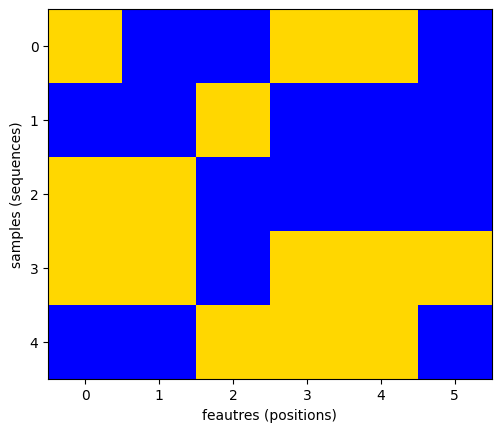

In [91]:
example_seqs = np.array([
  [0, 1, 1, 0, 0, 1],
  [1, 1, 0, 1, 1, 1],
  [0, 0, 1, 1, 1, 1],
  [0, 0, 1, 0, 0, 0],
  [1, 1, 0, 0, 0, 1]
])
plt.imshow(example_seqs, cmap=YlBu)
plt.xlabel("feautres (positions)")
plt.ylabel("samples (sequences)")
plt.show()

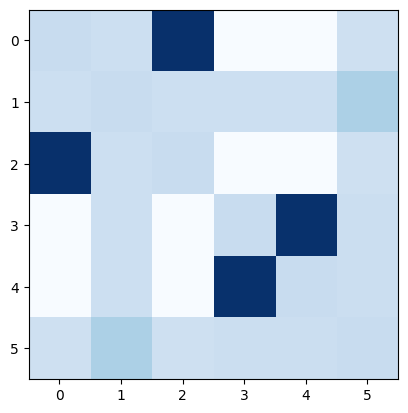

In [92]:
example_coevo = get_coevo(example_seqs, reg=0.01)
plt.imshow(example_coevo, cmap="Blues")

In [93]:
coevo = get_coevo(msa)

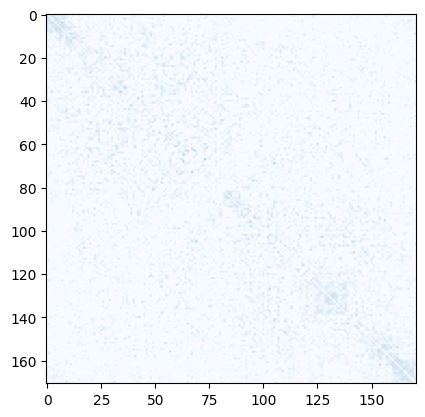

In [95]:
plt.imshow(coevo,vmin=0,vmax=0.3, cmap="Blues")